In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
with zipfile.ZipFile('C:/Users/MIGOMLOZ/Desktop/DS_Nanodegree/archive.zip', 'r') as zip:
    zip.extract('calendar.csv', 'C:/Users/MIGOMLOZ/Desktop/DS_Nanodegree/')
with zipfile.ZipFile('C:/Users/MIGOMLOZ/Desktop/DS_Nanodegree/archive.zip', 'r') as zip:
    zip.extract('listings.csv', 'C:/Users/MIGOMLOZ/Desktop/DS_Nanodegree/')
with zipfile.ZipFile('C:/Users/MIGOMLOZ/Desktop/DS_Nanodegree/archive.zip', 'r') as zip:
    zip.extract('reviews.csv', 'C:/Users/MIGOMLOZ/Desktop/DS_Nanodegree/')

In [3]:
os.chdir('C:/Users/MIGOMLOZ/Desktop/DS_Nanodegree/')  
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews =  pd.read_csv('reviews.csv')

In [4]:
col = 'id', 'space', 'host_since', 'host_response_time',\
'host_response_rate', 'host_is_superhost','host_total_listings_count',\
'host_verifications', 'host_has_profile_pic', 'host_identity_verified',\
'neighbourhood_group_cleansed', 'property_type', 'room_type', 'accommodates',\
'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',\
'price', 'security_deposit',\
'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',\
'maximum_nights', 'calendar_updated', 'has_availability',\
'availability_30', 'availability_60', 'availability_90',\
'availability_365', 'number_of_reviews',\
'first_review', 'last_review', 'review_scores_rating',\
'review_scores_accuracy', 'review_scores_cleanliness',\
'review_scores_checkin', 'review_scores_communication',\
'review_scores_location', 'review_scores_value', 'reviews_per_month'

In [5]:
listings=listings[[c for c in listings.columns if c in col]]

In [6]:
# Dejar apartamentos que estuvieron disponibles al menos un día del 2016
calendar['available_num'] = np.where(calendar['available'] == 't', 1,0)
calendar['available_max'] = calendar.groupby('listing_id')['available_num'].transform('max')
calendar = calendar[['listing_id', 'available_max']]
calendar = calendar.loc[calendar['available_max'] == 1]
calendar = calendar[['listing_id']]
calendar = calendar.drop_duplicates()

In [7]:
df = calendar.merge(listings, left_on= 'listing_id', right_on = 'id')
# 3,723 apartaments

In [8]:
# Build host duration variable
df['host_since_date']= pd.to_datetime(df['host_since'])
df['today'] = pd.to_datetime("today")
df['host_years'] = (df['today'] - df['host_since_date']) / np.timedelta64(365, 'D')

# last review
df['last_review']= pd.to_datetime(df['last_review'])
df['review_months'] = (df['today'] - df['last_review']) / np.timedelta64(30, 'D')

In [9]:
# Response time to numeric
conditions = [
    (df['host_response_time'] == 'within an hour'),
    (df['host_response_time'] == 'within a few hours'),
    (df['host_response_time'] == 'within a day'),
    (df['host_response_time'] == 'a few days or more')
    ]
values = [4, 3, 2, 1]
df['host_response_time_num'] = np.select(conditions, values)

# Response rate to num
df['host_response_rate'] = df['host_response_rate'].replace('[\%]', '', regex=True).astype(float)
df['host_response_rate'] = df['host_response_rate'].fillna(0)
df['host_response_rate'] = df['host_response_rate'].astype(int)

# verifications list to numeric
df['verifications_len'] = df.host_verifications.map(len)

# superhost to numeric
df['host_is_superhost'] = np.where(df['host_is_superhost'] == 't', 1,0)

# superhost to numeric
df['host_is_superhost'] = np.where(df['host_is_superhost'] == 't', 1,0)

# fill nulls with zero when needed
df['security_deposit'] = df['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
df['security_deposit'] = df['security_deposit'].fillna(0)
df['security_deposit'] = df['security_deposit'].astype(int)

# extra people fee
df['extra_people'] = df['extra_people'].replace('[\$,]', '', regex=True).astype(float)
df['extra_people'] = df['extra_people'].fillna(0)
df['extra_people'] = df['extra_people'].astype(int)

# cleaning fee
df['cleaning_fee'] = df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
df['cleaning_fee'] = df['cleaning_fee'].fillna(0)
df['cleaning_fee'] = df['cleaning_fee'].astype(float)

# calendar updated to num
df['calendar_updated'] = np.where(df['calendar_updated'] == 'today', '0 weeks ago', df['calendar_updated'])
df['calendar_updated'] = np.where(df['calendar_updated'] == 'never', '99 weeks ago', df['calendar_updated'])
df['calendar_updated'] = df['calendar_updated'].str.extract('(\d+)')
df['calendar_updated'] = df['calendar_updated'].astype(float)

# amenities list to numeric
df['amenities'] = df.amenities.map(len)

In [10]:
# price to num
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['price'] = df['price'].fillna(0)
df['price'] = df['price'].astype(int)

In [11]:
# drop unnecesary columns
df = df.drop(['host_since'], axis=1)
df = df.drop(['host_response_time'], axis=1)
df = df.drop(['host_since_date'], axis=1)
df = df.drop(['today'], axis=1)
df = df.drop(['square_feet'], axis=1) # too many missing values
df = df.drop(['id'], axis=1) # too many missing values
df = df.drop(['host_verifications'], axis=1)
df = df.drop(['last_review'], axis=1)
df = df.drop(['first_review'], axis=1)
df = df.drop(['space'], axis=1)
df = df.drop(['listing_id'], axis=1)

df = df.dropna()

In [12]:
target = df[['price']]
df = df.drop(['price'], axis=1)
# Categorical to dummies
df = pd.get_dummies(df)

In [13]:
# Train and test samples
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3, random_state=10)

In [14]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [15]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [16]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ..............model__alpha=0.1;, score=-1966.770 total time=   0.0s
[CV 2/5] END ..............model__alpha=0.1;, score=-2088.590 total time=   0.0s
[CV 3/5] END ..............model__alpha=0.1;, score=-5722.929 total time=   0.0s
[CV 4/5] END ..............model__alpha=0.1;, score=-2570.337 total time=   0.0s
[CV 5/5] END ..............model__alpha=0.1;, score=-3138.181 total time=   0.0s
[CV 1/5] END ..............model__alpha=0.2;, score=-1948.561 total time=   0.0s
[CV 2/5] END ..............model__alpha=0.2;, score=-2046.657 total time=   0.0s
[CV 3/5] END ..............model__alpha=0.2;, score=-5718.281 total time=   0.0s
[CV 4/5] END ..............model__alpha=0.2;, score=-2578.424 total time=   0.0s
[CV 5/5] END ..............model__alpha=0.2;, score=-3132.090 total time=   0.0s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-1932.419 total time=   0.0s
[CV 2/5] END model__alpha=0.30000000000000004

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [17]:
search.best_params_

{'model__alpha': 0.7000000000000001}

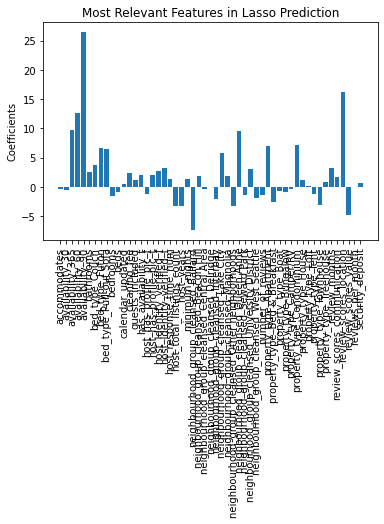

In [18]:
coef = search.best_estimator_.named_steps['model'].coef_
feature_names = sorted(df)
relevant_features = [feature_names[i] for i in range(len(feature_names)) if coef[i] != 0]

# plot the relevant features
plt.bar(relevant_features, coef[coef != 0])
plt.xticks(rotation=90)
plt.ylabel('Coefficients')
plt.title('Most Relevant Features in Lasso Prediction')
plt.show()

In [22]:
#coef = lasso.coef_
variable_names = X_train.columns

table = pd.DataFrame({'Variable Name': variable_names, 'Coefficient': coef})

# Get the top 15 most important variables
table = table.loc[table['Coefficient'].abs().sort_values(ascending=False).index][:15]

# Print table
print(table)

                                Variable Name  Coefficient
5                                    bedrooms    26.431984
68                  room_type_Entire home/apt    16.250019
4                                   bathrooms    12.690958
3                                accommodates     9.698379
42      neighbourhood_group_cleansed_Downtown     9.521042
30                     host_response_time_num    -7.369377
55                         property_type_Boat     7.241013
48    neighbourhood_group_cleansed_Queen Anne     6.964313
9                                cleaning_fee     6.708912
10                            guests_included     6.405995
38  neighbourhood_group_cleansed_Capitol Hill     5.834072
70                      room_type_Shared room    -4.803910
8                            security_deposit     3.730365
22                  review_scores_cleanliness     3.260269
27                          reviews_per_month    -3.244828
